## **Stock Price Prediction**

In [ ]:
import yfinance as yf

ticker = 'NVDA'
data = yf.download(ticker, start='2020-01-01', end='2024-05-01')
print('\n',data.columns)

[*********************100%%**********************]  1 of 1 completed


 Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [ ]:
print(data.head)

<bound method NDFrame.head of                  Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02   5.968750   5.997750   5.918000   5.997750   5.973632  237536000
2020-01-03   5.877500   5.945750   5.852500   5.901750   5.878019  205384000
2020-01-06   5.808000   5.931750   5.781750   5.926500   5.902670  262636000
2020-01-07   5.955000   6.044250   5.909750   5.998250   5.974130  314856000
2020-01-08   5.994000   6.051000   5.953750   6.009500   5.985336  277108000
...               ...        ...        ...        ...        ...        ...
2024-04-24  83.949997  84.082001  79.182999  79.677002  79.670456  512208000
2024-04-25  78.867996  83.322998  78.223000  82.632004  82.625214  424641000
2024-04-26  83.818001  88.331001  83.387001  87.735001  87.727791  551011000
2024-04-29  87.595001  87.991997  85.265999  87.757004  87.749794  388971000
2024-04-30  87.239998  88.819000  86.300003  8

**K-Means-Clustering Algorithim**

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


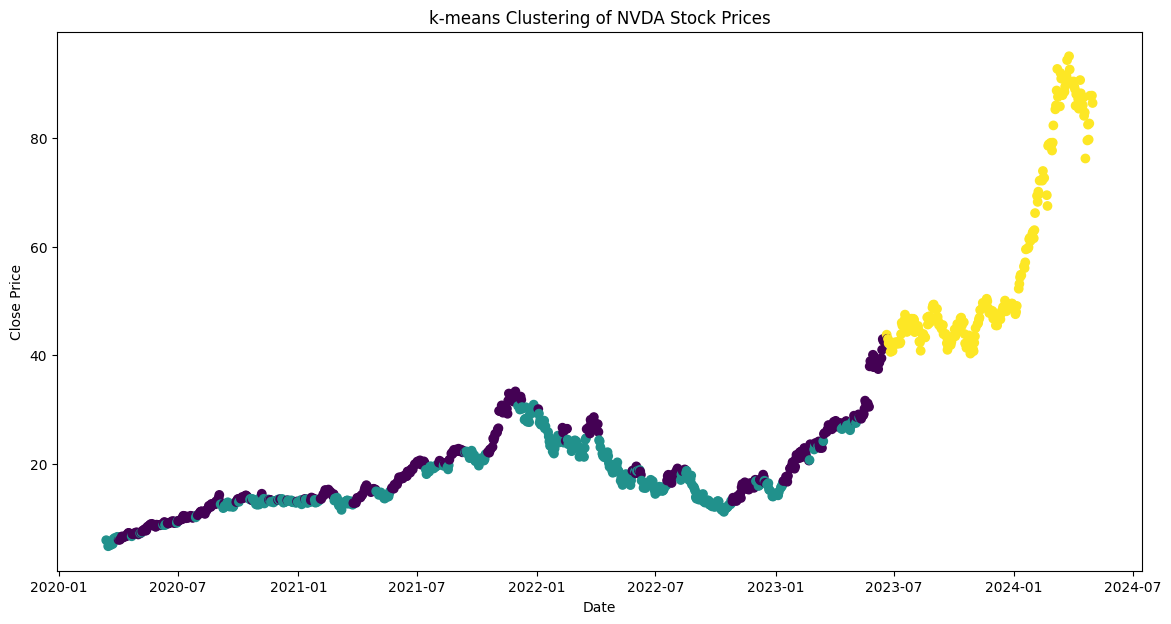

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# data collection
ticker = 'NVDA'
data = yf.download(ticker, start='2020-01-01', end='2024-05-01')

# feature engineering
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['RSI'] = compute_rsi(data['Close'])
data.dropna(inplace=True)

#k-means Clustering
features = data[['SMA_20', 'SMA_50', 'RSI']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# applying the k-means-clustering algo
kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(14, 7))
plt.scatter(data.index, data['Close'], c=data['Cluster'], cmap='viridis')
plt.title(f'k-means Clustering of {ticker} Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


**Algorithim Analysis**

The visualization generated from the K-Means clustering algorithm illustrates the clustering of NVIDIA (NVDA) stock prices based on technical indicators such as SMA_20, SMA_50, and RSI. Each point on the scatter plot represents a closing price of NVDA stock at a specific date, with colors indicating different clusters identified by the algorithm. The purple cluster primarily covers the earlier dates (2020-01 to around 2023-01) with relatively lower closing prices, suggesting a stable or accumulating phase. The teal cluster appears more frequently during the middle period (2021-01 to around 2023-01), indicating a period of volatility or consolidation with moderate price fluctuations. The yellow cluster dominates the later dates (from around 2023-01 to 2024-05), corresponding to a significant price increase, marking a bullish phase. The temporal progression shows the stock price transitioning from low and stable in the early stage, through a volatile middle stage, to a strong upward trend in the recent stage. The clustering effectively identifies different market phases, providing insights into historical price movements and potential future trends. This analysis can aid in developing trading strategies and predictive models by highlighting distinct market behaviors and trends over time.

# LSTM Model


In [ ]:
import time
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import Callback

ticker = 'NVDA'
df = yf.download(ticker, start='2020-01-01', end='2024-05-01')

# normalize dataset from yfinance
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

train_data = scaled_data[0:int(len(scaled_data) * 0.8)]
test_data = scaled_data[int(len(scaled_data) * 0.8):] #final 20%

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

class LossHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"epoch {epoch + 1}, loss from model: {logs['loss']}")

loss_history = LossHistory()

start_time = time.time()

model.fit(X_train, y_train, batch_size=1, epochs=2, callbacks=[loss_history])

training_time = time.time() - start_time
print(f"time taken: {training_time:.2f} seconds")

[*********************100%%**********************]  1 of 1 completed


Epoch 1/2
810/810 [==============================] - 30s 32ms/step - loss: 6.3508e-04
Epoch 2/2
810/810 [==============================] - 27s 33ms/step - loss: 3.0473e-04
time taken: 57.28 seconds


5/5 [==============================] - 0s 31ms/step


<ipython-input-9-a1a7a53aa620>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = test_predict


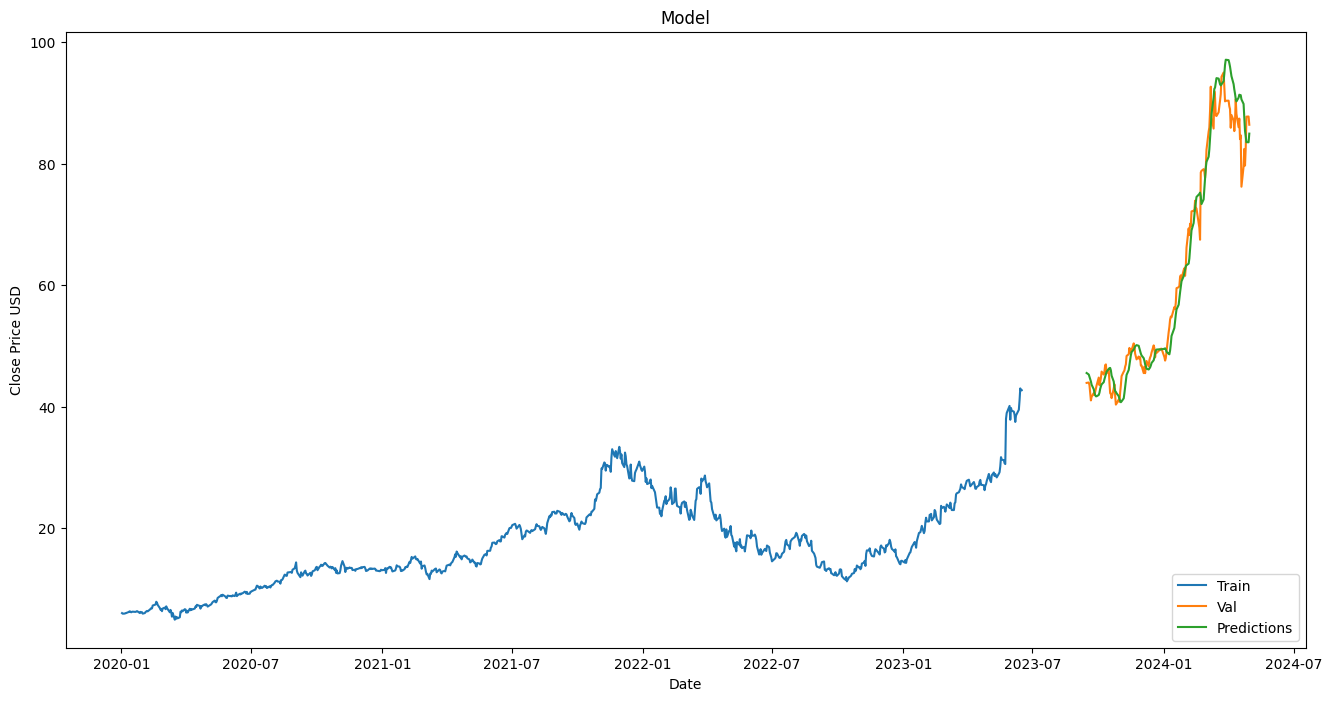

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# scale model predictions to normal scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

valid = df[int(len(df) * 0.8) + time_step + 1:]
valid['Predictions'] = test_predict

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(df['Close'][:int(len(df) * 0.8)])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

LSTM ANALYSIS

The LSTM model for predicting the Nvidia stock prices shows great results. The loss decreased significantly over two epochs, ending at 3.0473e-04.  Mean squared error was used for the loss and since the loss decreased this means the model is improving its predictions. The plot shows the model's predictions in green, which closely follow the actual validation prices in orange. There are still some differences, especially towards the end, where the predictions slightly are different from the actual prices, but overall, the model performs well.  The model did a great job predicting the stock price given the previous stock data we fed it.


[*********************100%%**********************]  1 of 1 completed



 Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


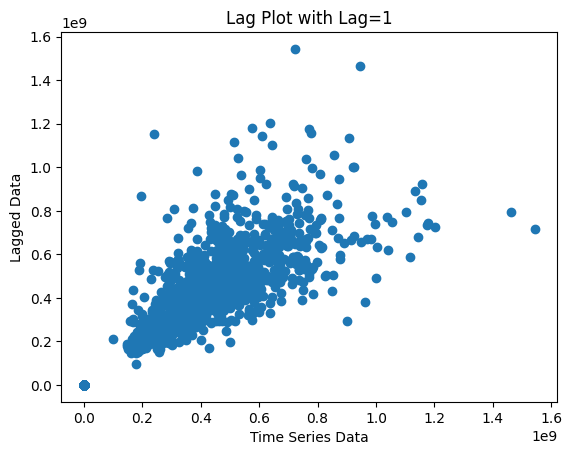

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ticker = 'NVDA'
data = yf.download(ticker, start='2020-01-01', end='2024-05-01')
print('\n',data.columns)

# lag plot with lag = 1
pd.plotting.lag_plot(data, lag=1)
plt.title('Lag Plot with Lag=1')
plt.xlabel('Time Series Data')
plt.ylabel('Lagged Data')
plt.show()

The points on the plot above are distributed on a diagonal line from bottom left to top right which means that the values of the time series are positively correlated with their lagged values. To put it in simple terms, if a stock price was high today, it will also be high tomorrow.

The clustering in the plot shows stability in the stock price over a short period of time. Meaning that the price of the stock lingers around that range and rarely goes out of it (which is depicted by the outliers in the plot)

This lag plot shows the autocorrelation in our stock data which helps us analyze time series and forecasting of its price. If the plot had a more random pattern it would mean that there is no autocorrelatoin in the stock prices, but since there is a linear correlation, we can see the autocorrelation of the plot above.

[*********************100%%**********************]  1 of 1 completed



 Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


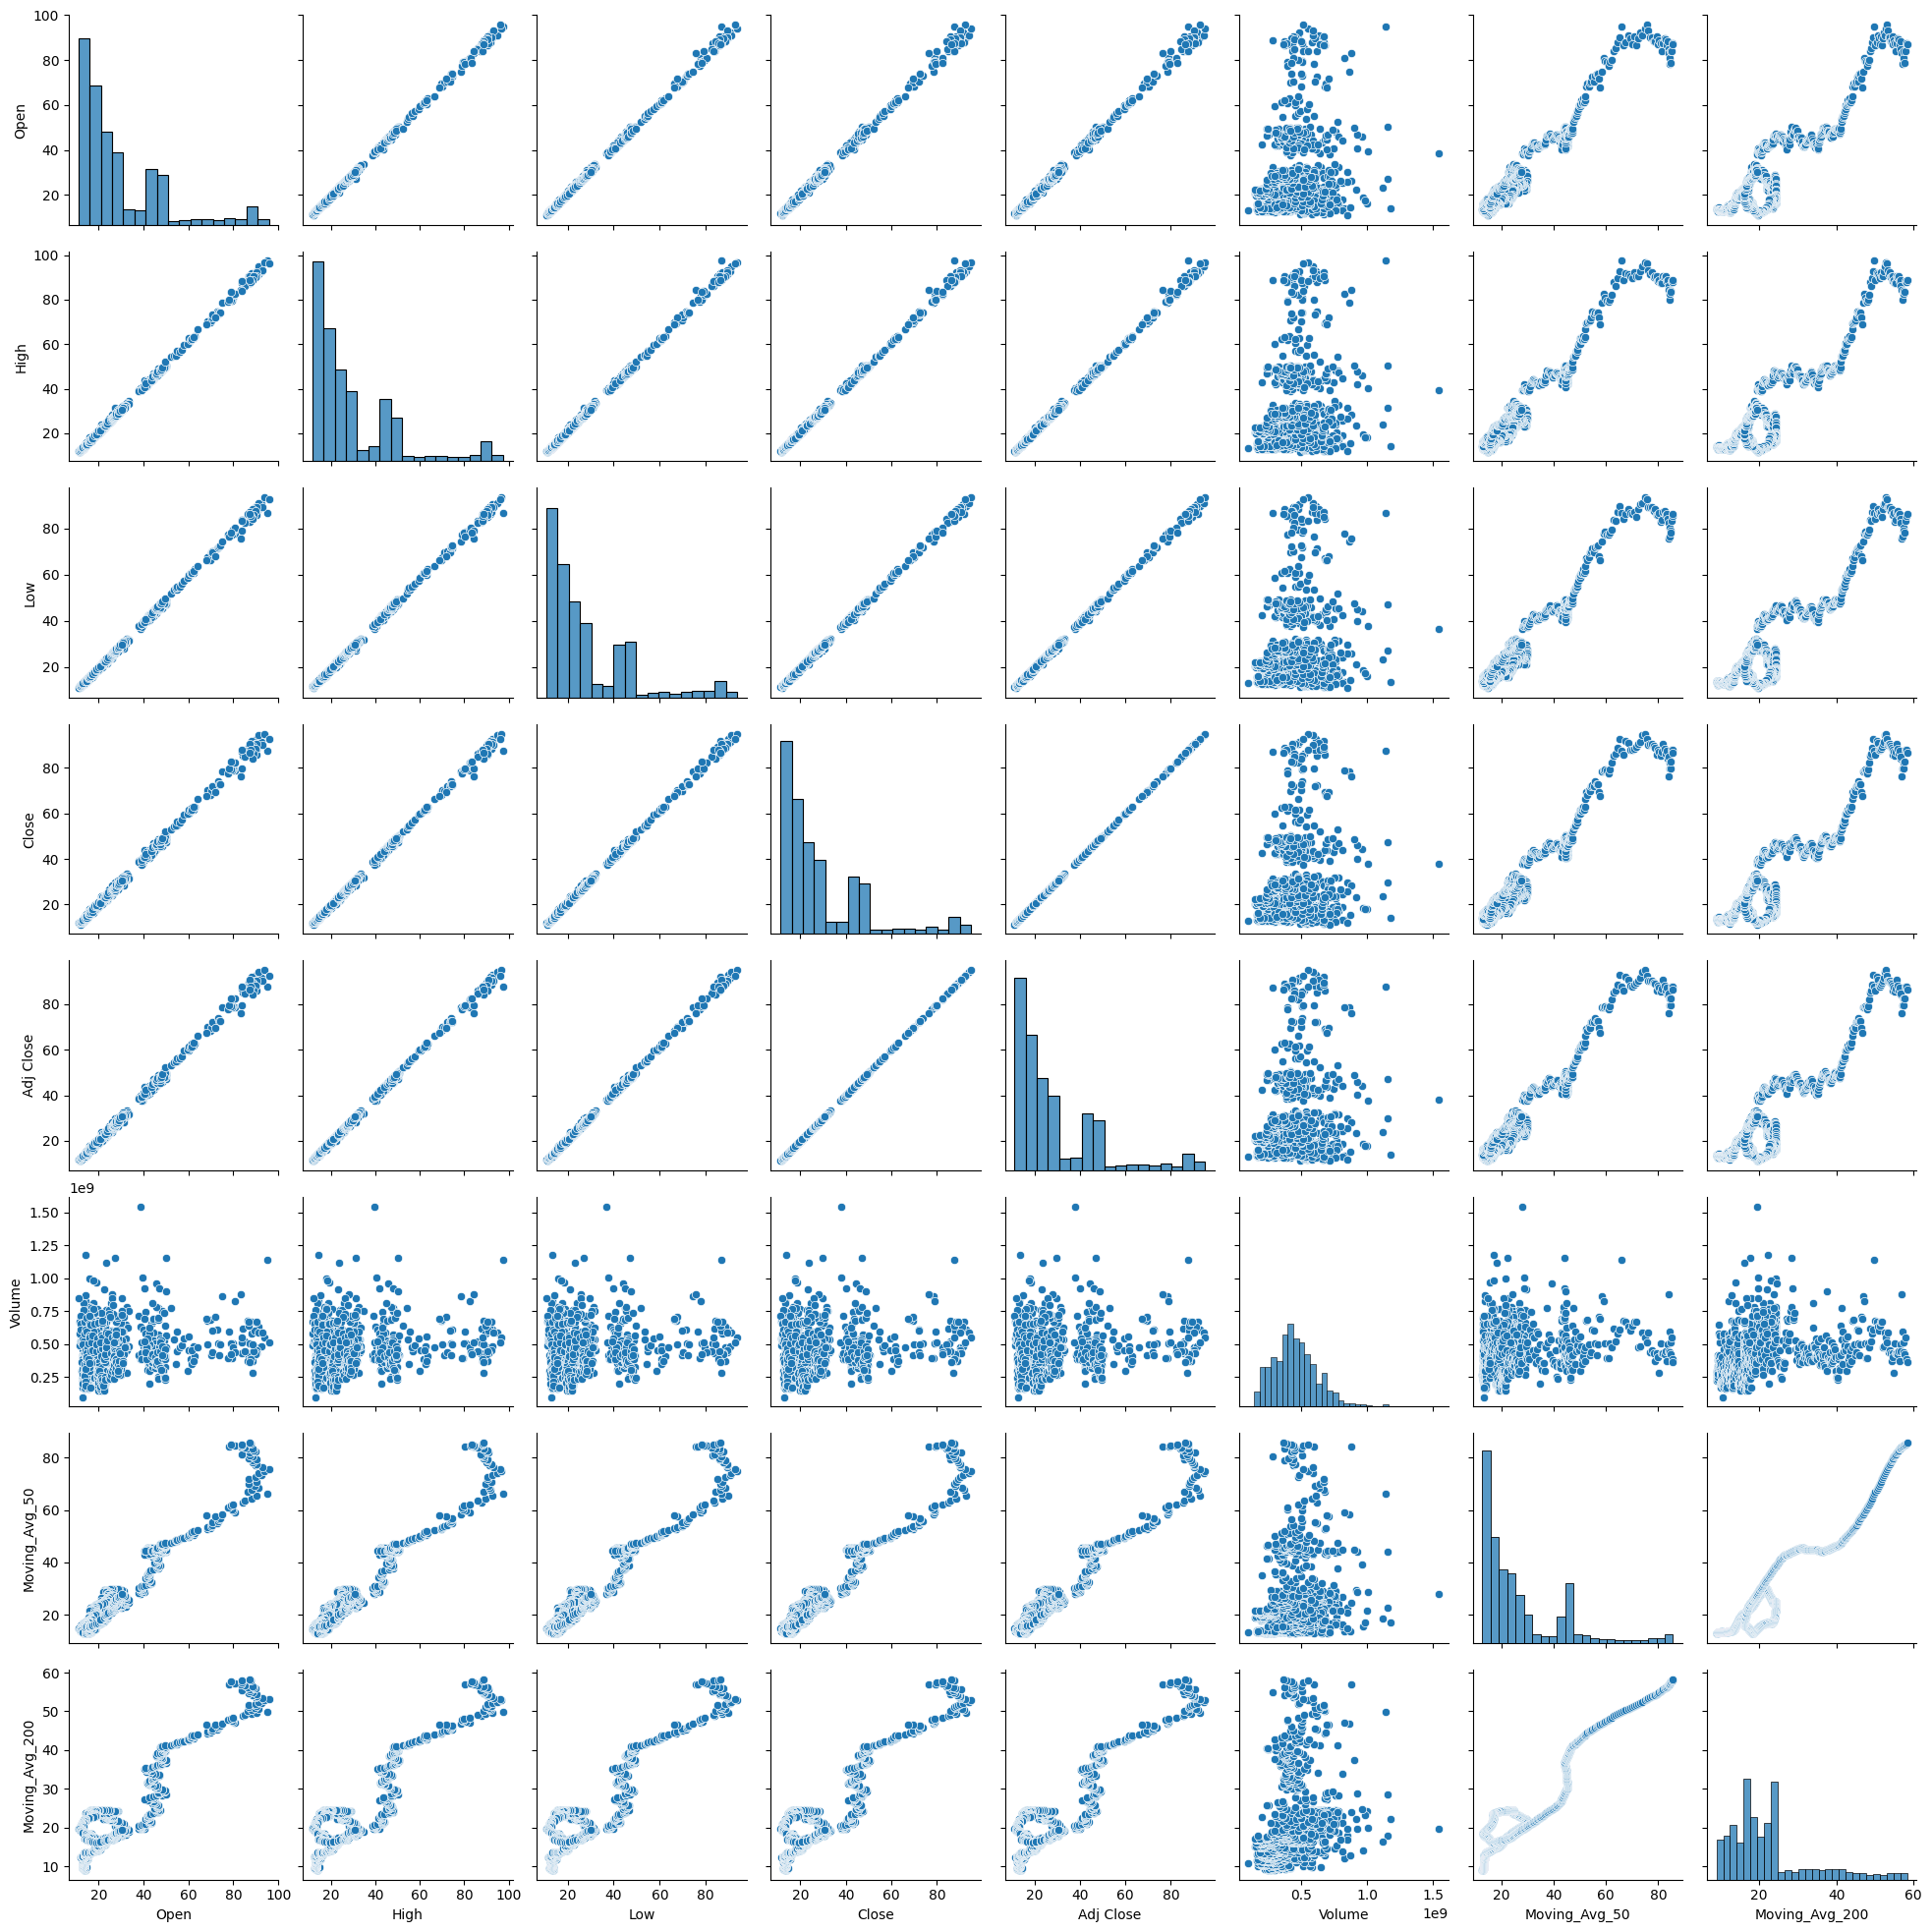

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

ticker = 'NVDA'
data = yf.download(ticker, start='2020-01-01', end='2024-05-01')
print('\n',data.columns)

if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

# calculate 50-day and 200-day moving averages
data['Moving_Avg_50'] = data['Close'].rolling(window=50).mean()
data['Moving_Avg_200'] = data['Close'].rolling(window=200).mean()

# Select columns for the pair plot
data_selected = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Moving_Avg_50', 'Moving_Avg_200']]

# Drop rows with NaN values that result from moving average calculations
data_selected.dropna(inplace=True)

sns.pairplot(data_selected)
plt.show()

**Histograms:**

Open, High, Low, Close, Adj Close: Left-skewed distributions, indicating most prices are lower.

Volume: Spread-out distribution, indicating varying trading activity.

Moving Averages (50-day, 200-day): Skewed distributions, reflecting lower stock prices over time.

**Scatter Plots:**

Open, High, Low, Close, Adj Close: Strong linear relationships among Open, High, Low, Close, Adj Close.

Volume vs. Prices: No strong linear relationship; volume spikes occur at various price levels.

Moving Averages vs. Prices: Strong correlations, indicating trends over different periods

**Conclusion:**

Price Correlation: Strong linear trends among price variables.

Volume: Weak correlation with price; volume spikes are inconsistent with price levels.

Moving Averages: Strong alignment with price trends.

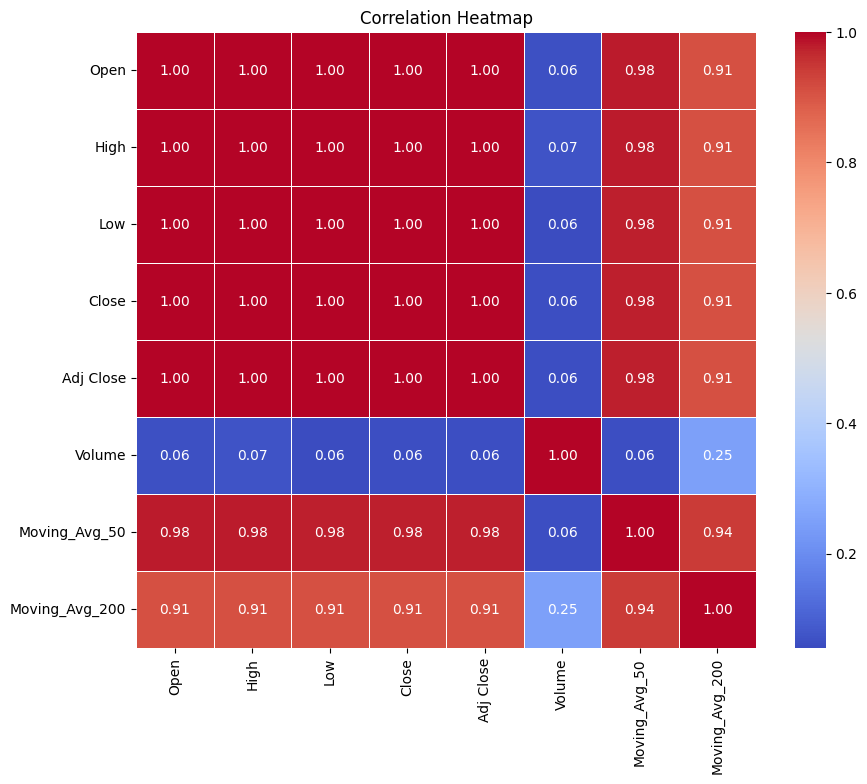

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Moving_Avg_50', 'Moving_Avg_200']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows a couple of important things:

**Price Variables** move together perfectly.

**Moving Averages** are effective and good for trend analysis

**Volume** doesn't strongly affect prices or trends

In [ ]:
pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 804.5 kB/s eta 0:00:00


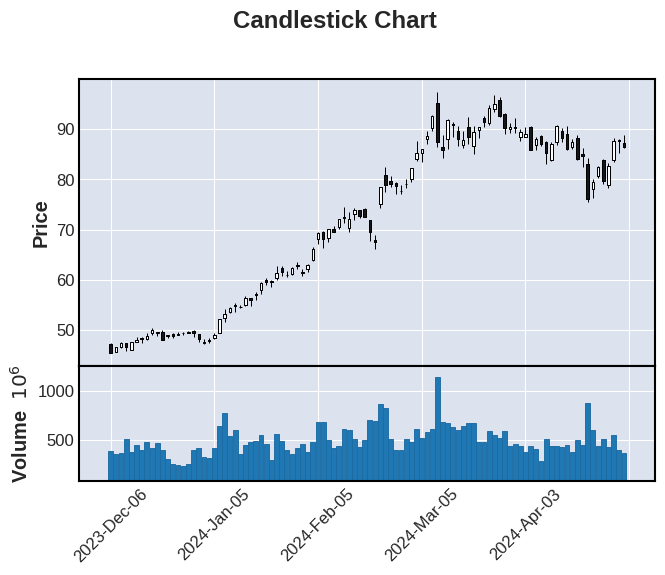

In [ ]:
import pandas as pd
import mplfinance as mpf

if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

# plot of last 100 data points
data_subset = data.tail(100)
data_candlestick = data_subset[['Open', 'High', 'Low', 'Close', 'Volume']]

mpf.plot(data_candlestick, type='candle', volume=True, title='Candlestick Chart')


The chart shows us the change in price of the stock from December 6th of 2023 all the way to April 3rd of 2024 and how the price varied over that time. We can see that from the time period plotted above the average price of the stock rose from ~25\$ to ~95\$ and then falling slightly to ~85$\.

The problem with using candlestick is that we can only plot a certain amount of points at a time since plotting too many points makes the candlelight chart look like a line graph. To look at the data at a different point in time we alter our code to show a different period of time from the dataset.

